In [1]:
import tensorflow as tf

# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())
else:
  strategy = tf.distribute.get_strategy() # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
  print('Running on CPU instead')

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.52.232.98:8470
REPLICAS:  8


In [2]:
import pandas as pd
import numpy as np

In [3]:
# Let's load the data again, this time setting "Date" as the index
df = pd.read_csv("./viable_dataset.csv", parse_dates=['Date'], index_col='Date')
df.head()


PS_Q_DAY  TPS_Q1_DAY  TWAS_DAF_QIN_DAY  DIGESTED_SLUDGE_QOUT_DAY  \
Date                                                                           
2012-01-01    1197.0       199.5             242.5                       414   
2012-01-02    1197.0       199.5             165.5                       392   
2012-01-03    1197.0       199.5             241.5                       428   
2012-01-04    1197.0       170.0             194.0                       354   
2012-01-05    1197.0       199.5             193.5                       383   

            BIOGAS_PRODUCTION_Q_DAY  \
Date                                  
2012-01-01                    5.064   
2012-01-02                    5.293   
2012-01-03                    5.609   
2012-01-04                    4.470   
2012-01-05                    2.848   

            DIG_SLUDGE_DEWATER_DS_AFTER_DEWATER_3_PER_WEEK  
Date                                                        
2012-01-01                                            32.1  
2012-01-02                                            32.1  
2012-01-03                                            32.1  
2012-01-04                                            31.8  
2012-01-05                                            31.4

In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Assume df is your DataFrame with the time series data

# Convert DataFrame to numpy array and scale to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df.values)

# Define a function to convert the time series data to the right shape for LSTM
def create_dataset(dataset, look_back=1, forecast_horizon=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-forecast_horizon):
        X.append(dataset[i:(i+look_back), :])
        Y.append(dataset[(i+look_back):(i+look_back+forecast_horizon), :])
    return np.array(X), np.array(Y)

# Generate the dataset with a lookback of 30 days and forecast horizon of 7 days
look_back = 30
forecast_horizon = 7
X, Y = create_dataset(data, look_back, forecast_horizon)

# Split data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

from tensorflow.keras.layers import Reshape

with tpu_strategy.scope():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(forecast_horizon*Y.shape[2]))
    model.add(Reshape((forecast_horizon, Y.shape[2])))  # Reshape the output to match the target data
    model.compile(loss='mean_squared_error', optimizer='adam')


# Define early stopping based on validation loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Fit the model
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=32, verbose=2, callbacks=[es])

# Make predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)

# Reshape predictions back to original format
train_predict = train_predict.reshape(-1, forecast_horizon, Y.shape[2])
val_predict = val_predict.reshape(-1, forecast_horizon, Y.shape[2])

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict.reshape(-1, Y.shape[2])).reshape(-1, forecast_horizon, Y.shape[2])
Y_train = scaler.inverse_transform(Y_train.reshape(-1, Y.shape[2])).reshape(-1, forecast_horizon, Y.shape[2])
val_predict = scaler.inverse_transform(val_predict.reshape(-1, Y.shape[2])).reshape(-1, forecast_horizon, Y.shape[2])
Y_val = scaler.inverse_transform(Y_val.reshape(-1, Y.shape[2])).reshape(-1, forecast_horizon, Y.shape[2])


Running on TPU  ['10.52.232.98:8470']


Epoch 1/100
21/21 - 21s - loss: 0.1691 - val_loss: 0.0378 - 21s/epoch - 1s/step
Epoch 2/100
21/21 - 1s - loss: 0.0562 - val_loss: 0.0243 - 1s/epoch - 56ms/step
Epoch 3/100
21/21 - 1s - loss: 0.0411 - val_loss: 0.0200 - 1s/epoch - 57ms/step
Epoch 4/100
21/21 - 1s - loss: 0.0343 - val_loss: 0.0175 - 1s/epoch - 70ms/step
Epoch 5/100
21/21 - 1s - loss: 0.0310 - val_loss: 0.0175 - 1s/epoch - 67ms/step
Epoch 6/100
21/21 - 1s - loss: 0.0288 - val_loss: 0.0166 - 1s/epoch - 70ms/step
Epoch 7/100
21/21 - 1s - loss: 0.0264 - val_loss: 0.0159 - 1s/epoch - 51ms/step
Epoch 8/100
21/21 - 1s - loss: 0.0245 - val_loss: 0.0163 - 1s/epoch - 55ms/step
Epoch 9/100
21/21 - 1s - loss: 0.0229 - val_loss: 0.0157 - 1s/epoch - 58ms/step
Epoch 10/100
21/21 - 1s - loss: 0.0221 - val_loss: 0.0155 - 1s/epoch - 54ms/step
Epoch 11/100
21/21 - 1s - loss: 0.0219 - val_loss: 0.0154 - 1s/epoch - 56ms/step
Epoch 12/100
21/21 - 1s - loss: 0.0213 - val_loss: 0.0158 - 1s/epoch - 48ms/step
Epoch 13/100
21/21 - 1s - loss: 0.020

Feature: PS_Q_DAY
Train MAE: 87.79987287333533
Validation MAE: 105.5381402550446
Train MSE: 12992.03405263781
Validation MSE: 25137.538966173906
Train MAPE: 11.848982989120945
Validation MAPE: 16.29201488890037
++++++++++++++++++++++++++++
Feature: TPS_Q1_DAY
Train MAE: 32.75759867531076
Validation MAE: 33.45025486564135
Train MSE: 2113.7930365003285
Validation MSE: 2129.945854376559
Train MAPE: 47.147585722809545
Validation MAPE: 39.71308909719256
++++++++++++++++++++++++++++
Feature: TWAS_DAF_QIN_DAY
Train MAE: 48.40917954726781
Validation MAE: 47.863458342890695
Train MSE: 4361.622414213996
Validation MSE: 4336.315452022938
Train MAPE: 47.001201918639104
Validation MAPE: 61.56551164119978
++++++++++++++++++++++++++++
Feature: DIGESTED_SLUDGE_QOUT_DAY
Train MAE: 61.955049991503024
Validation MAE: 61.771360432443444
Train MSE: 7630.460854371962
Validation MSE: 7707.165590528528
Train MAPE: 15.43967213908955
Validation MAPE: 15.333987798794443
++++++++++++++++++++++++++++
Feature: BIOG

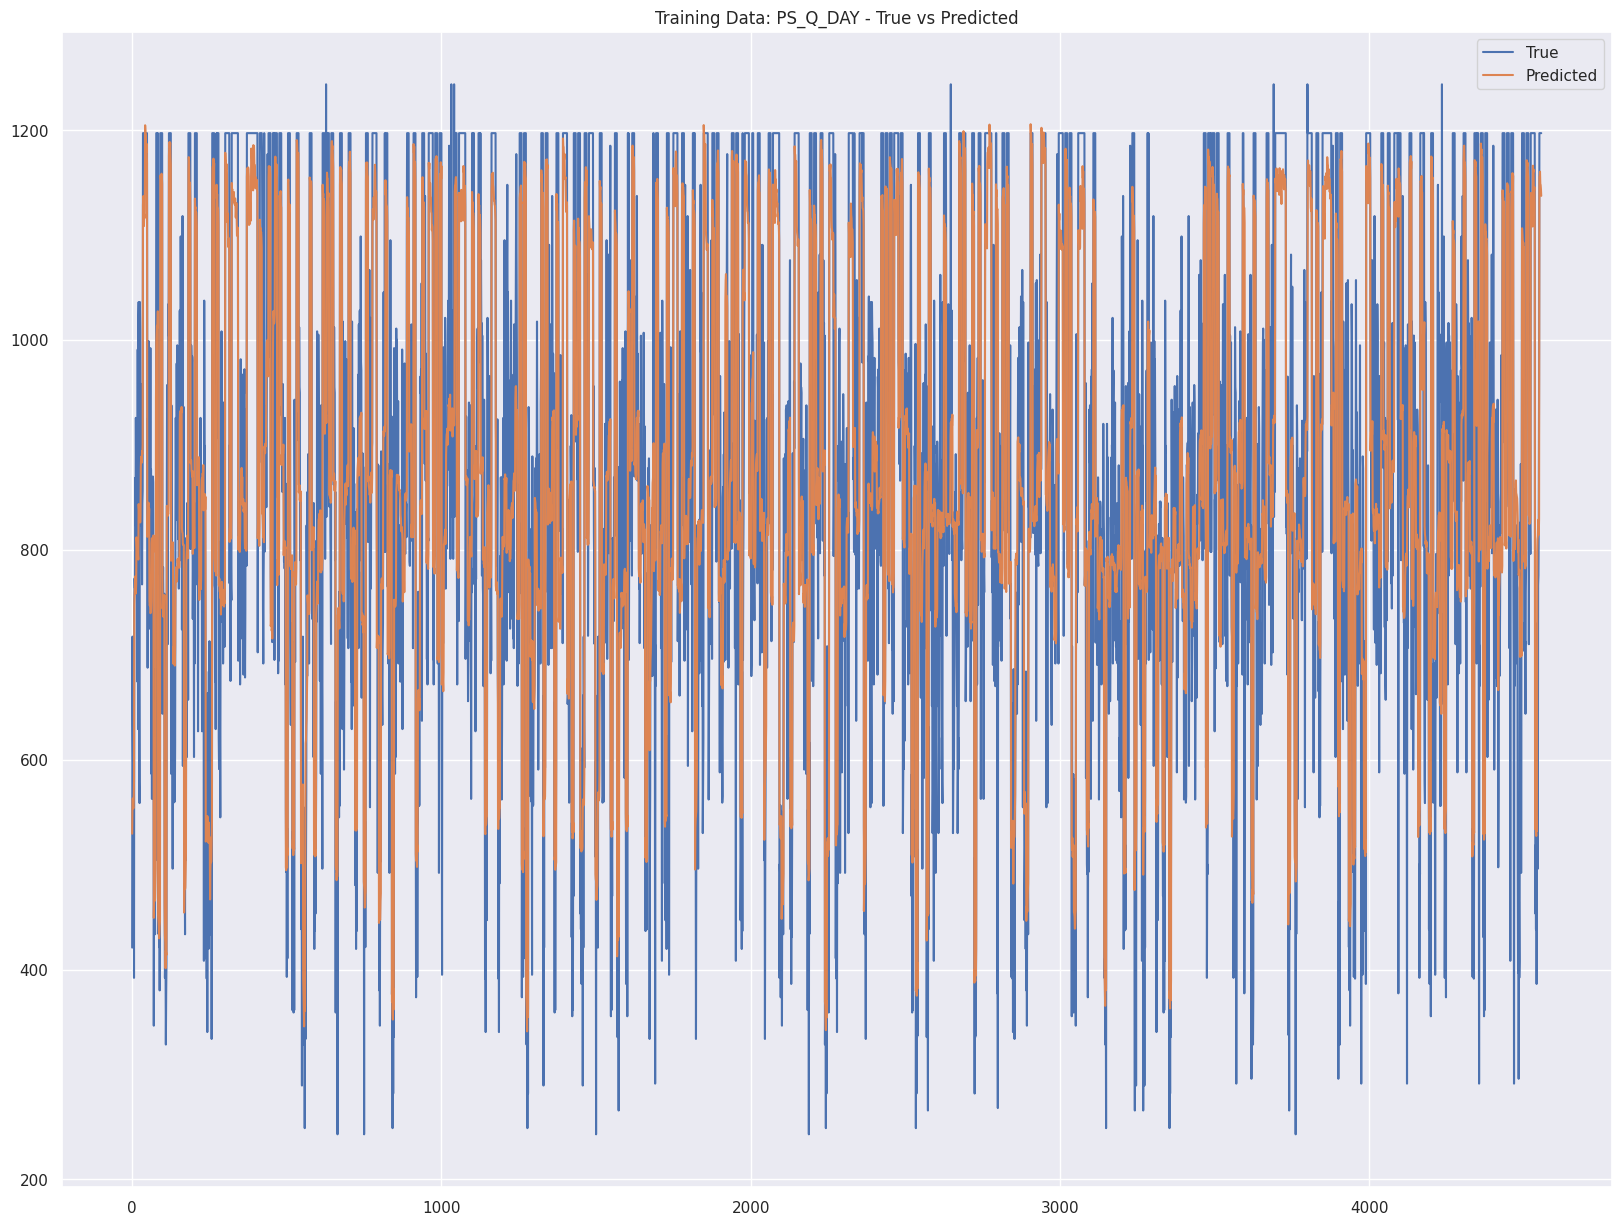

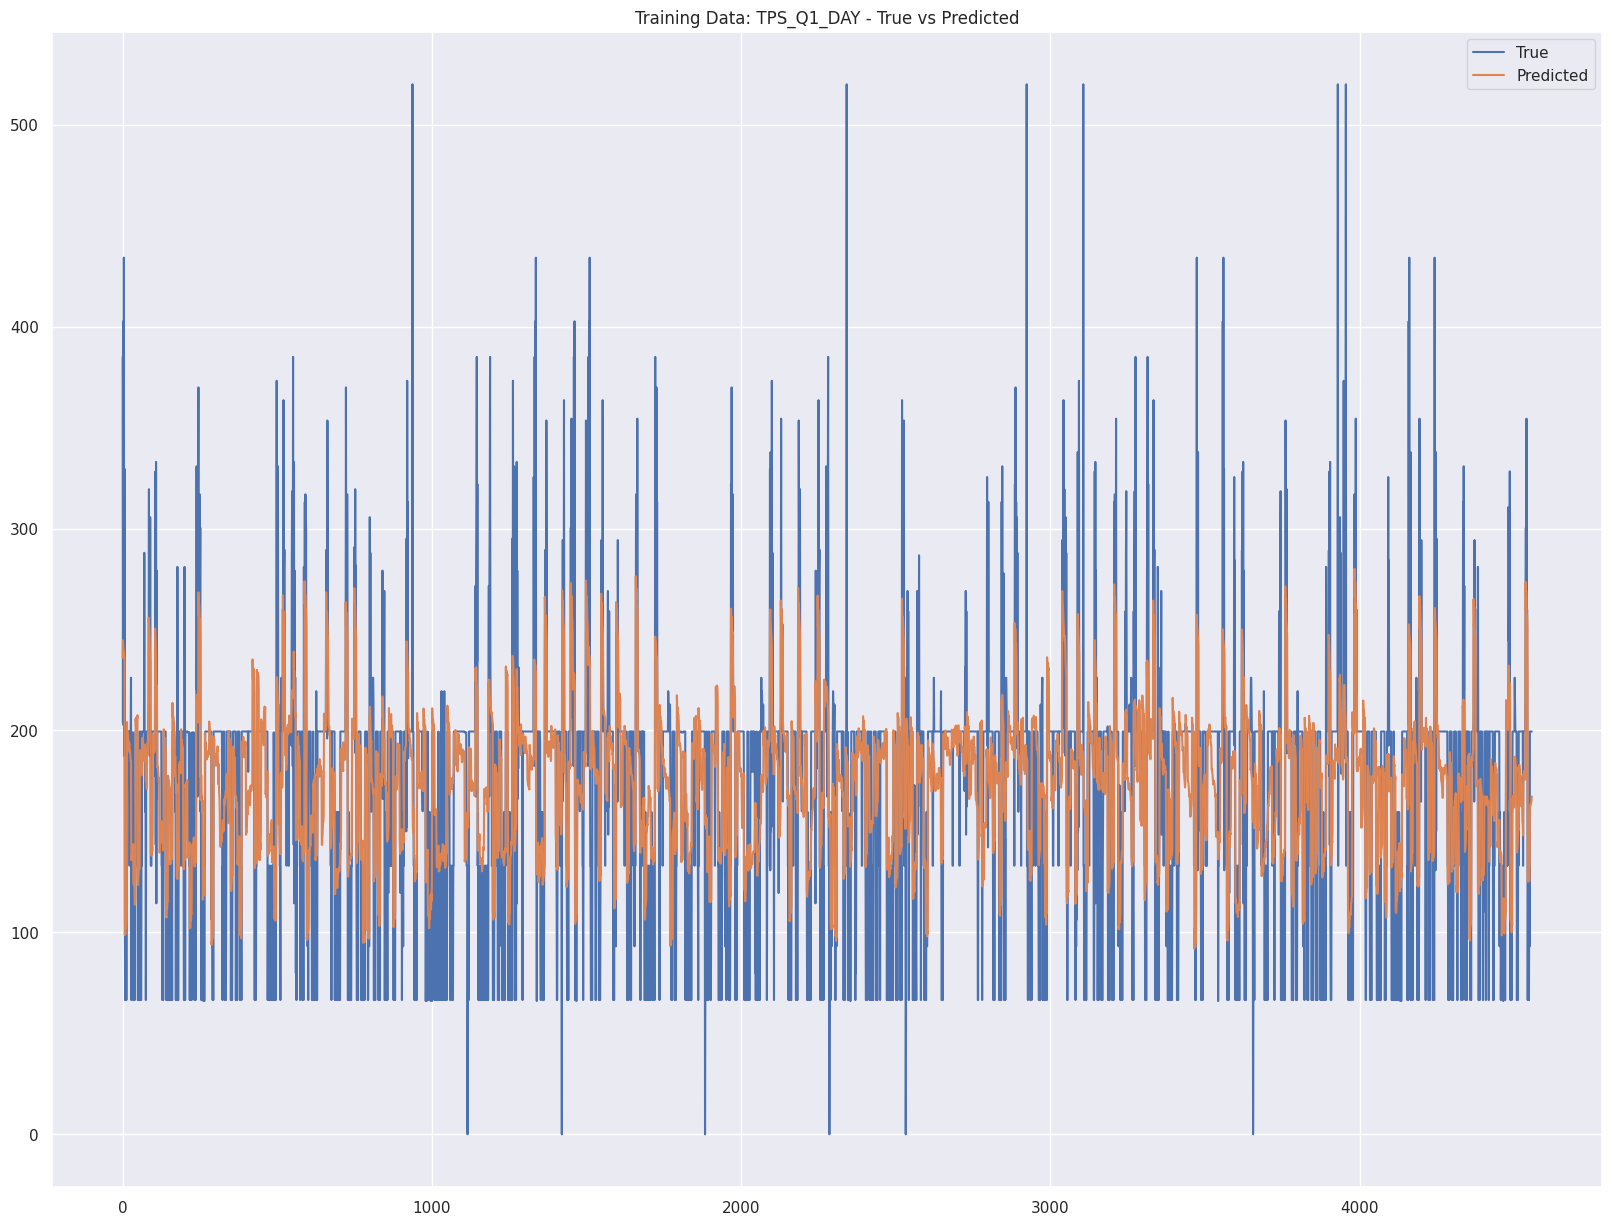

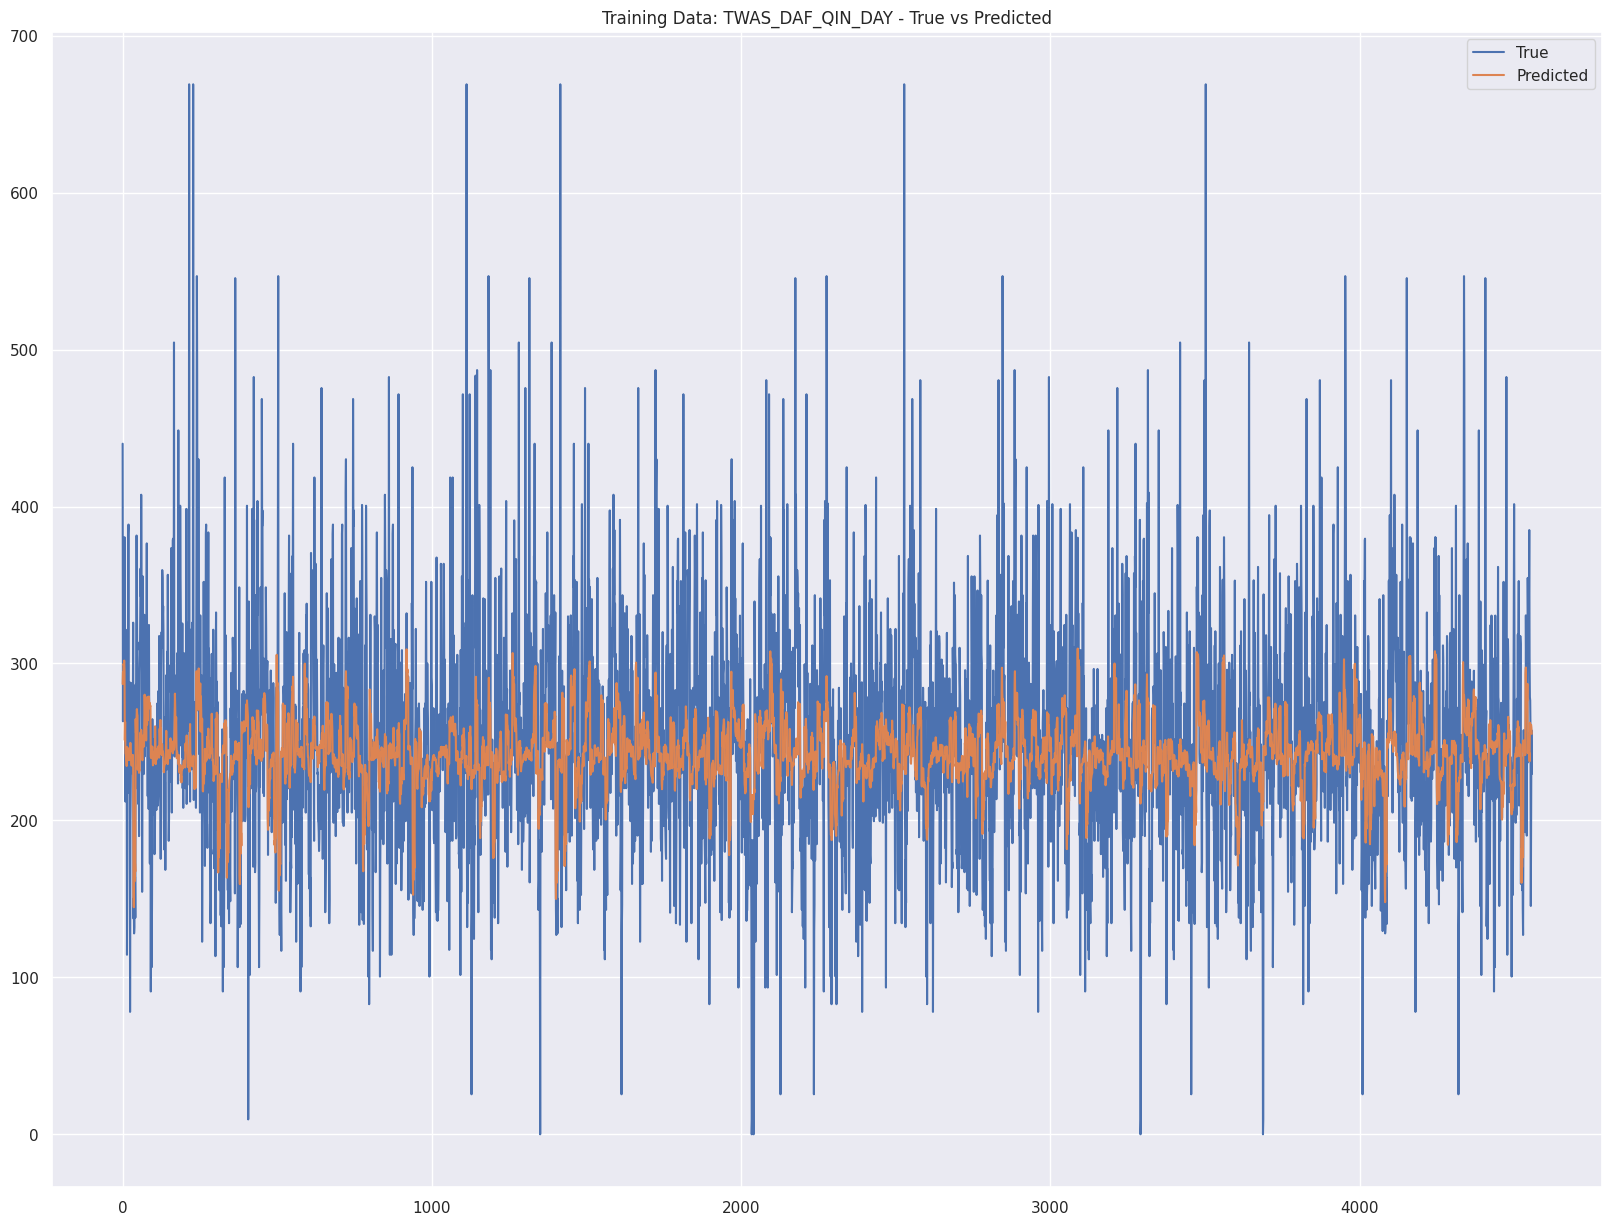

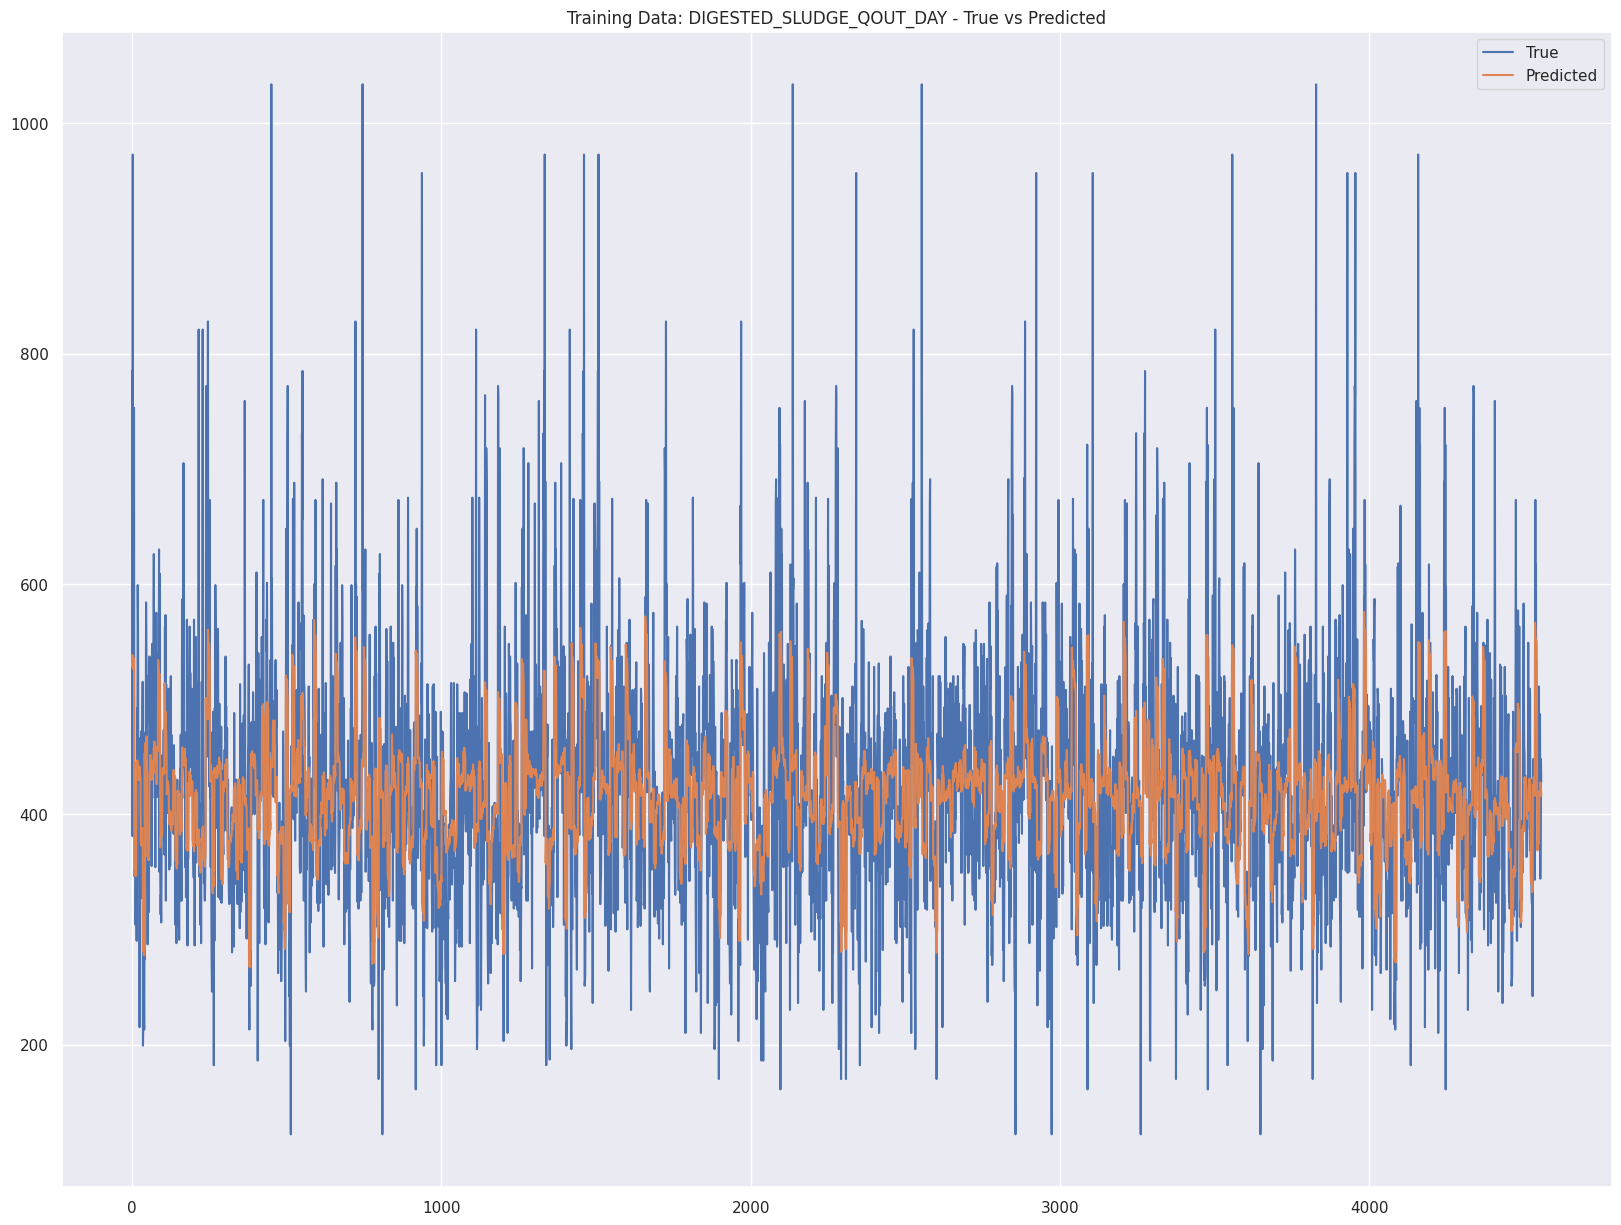

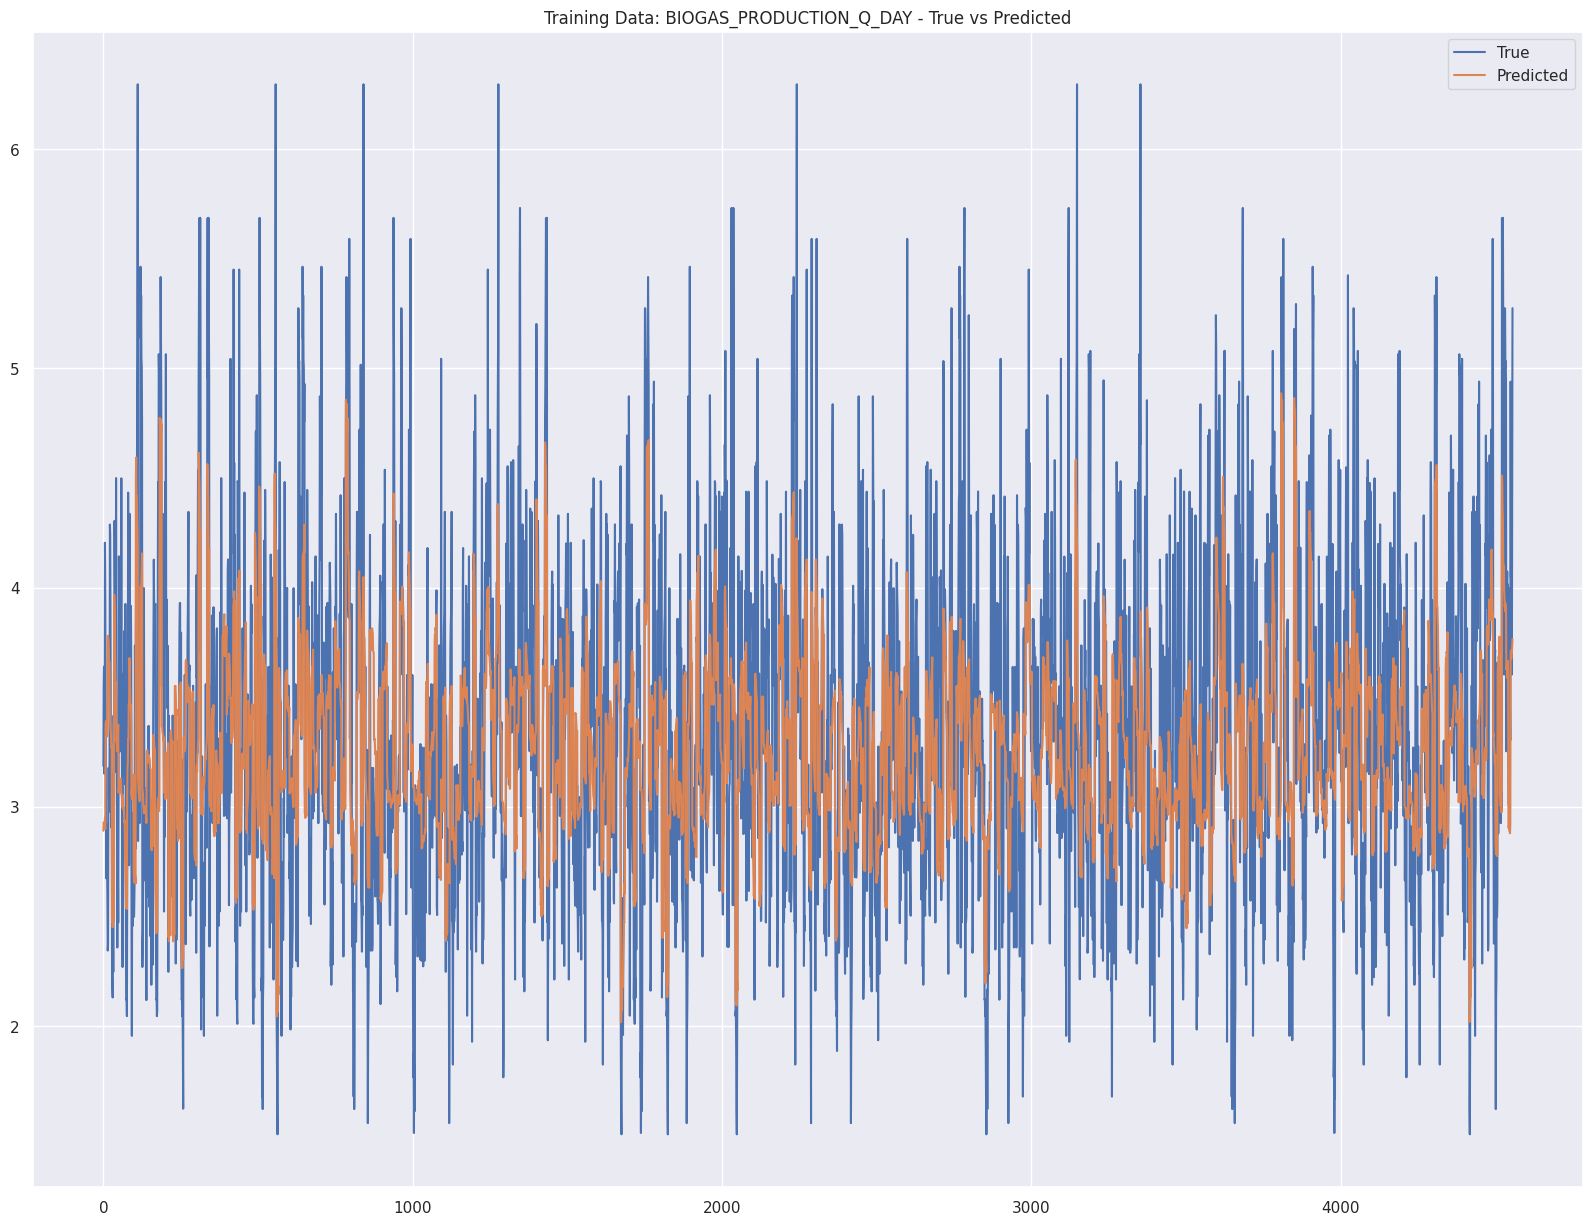

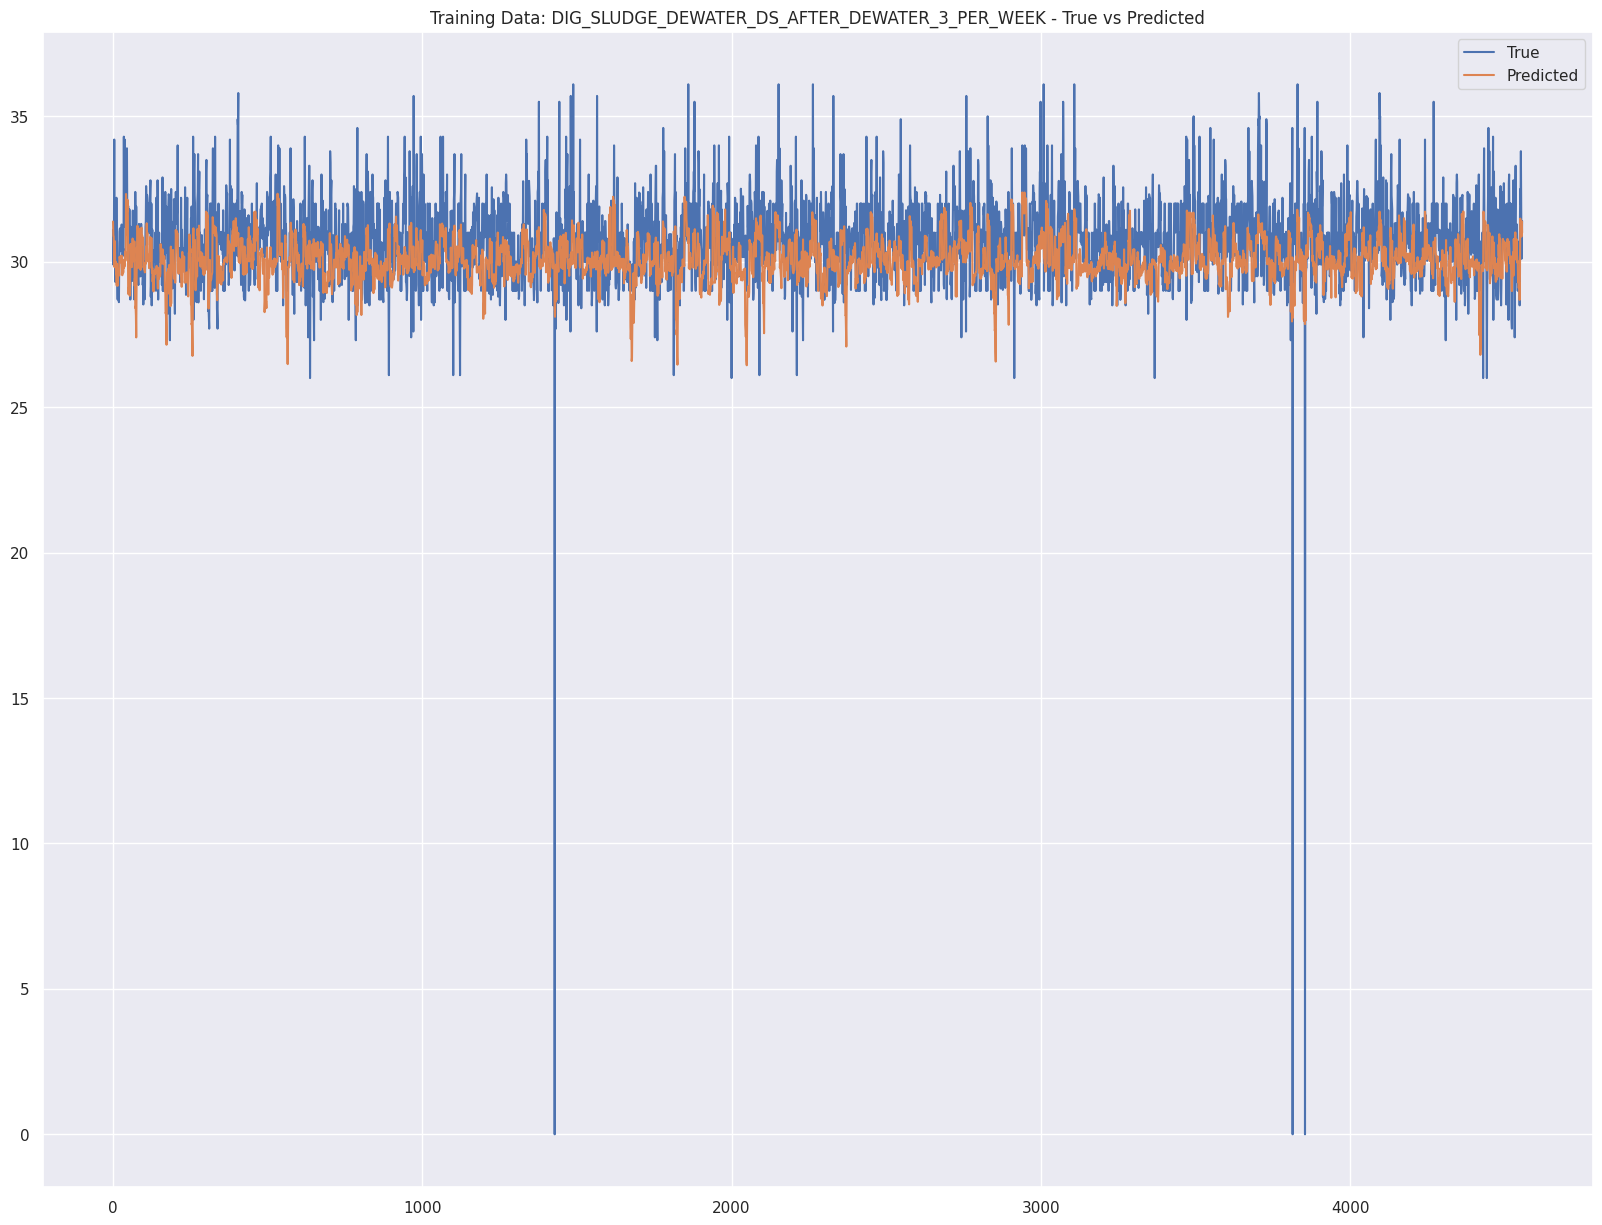

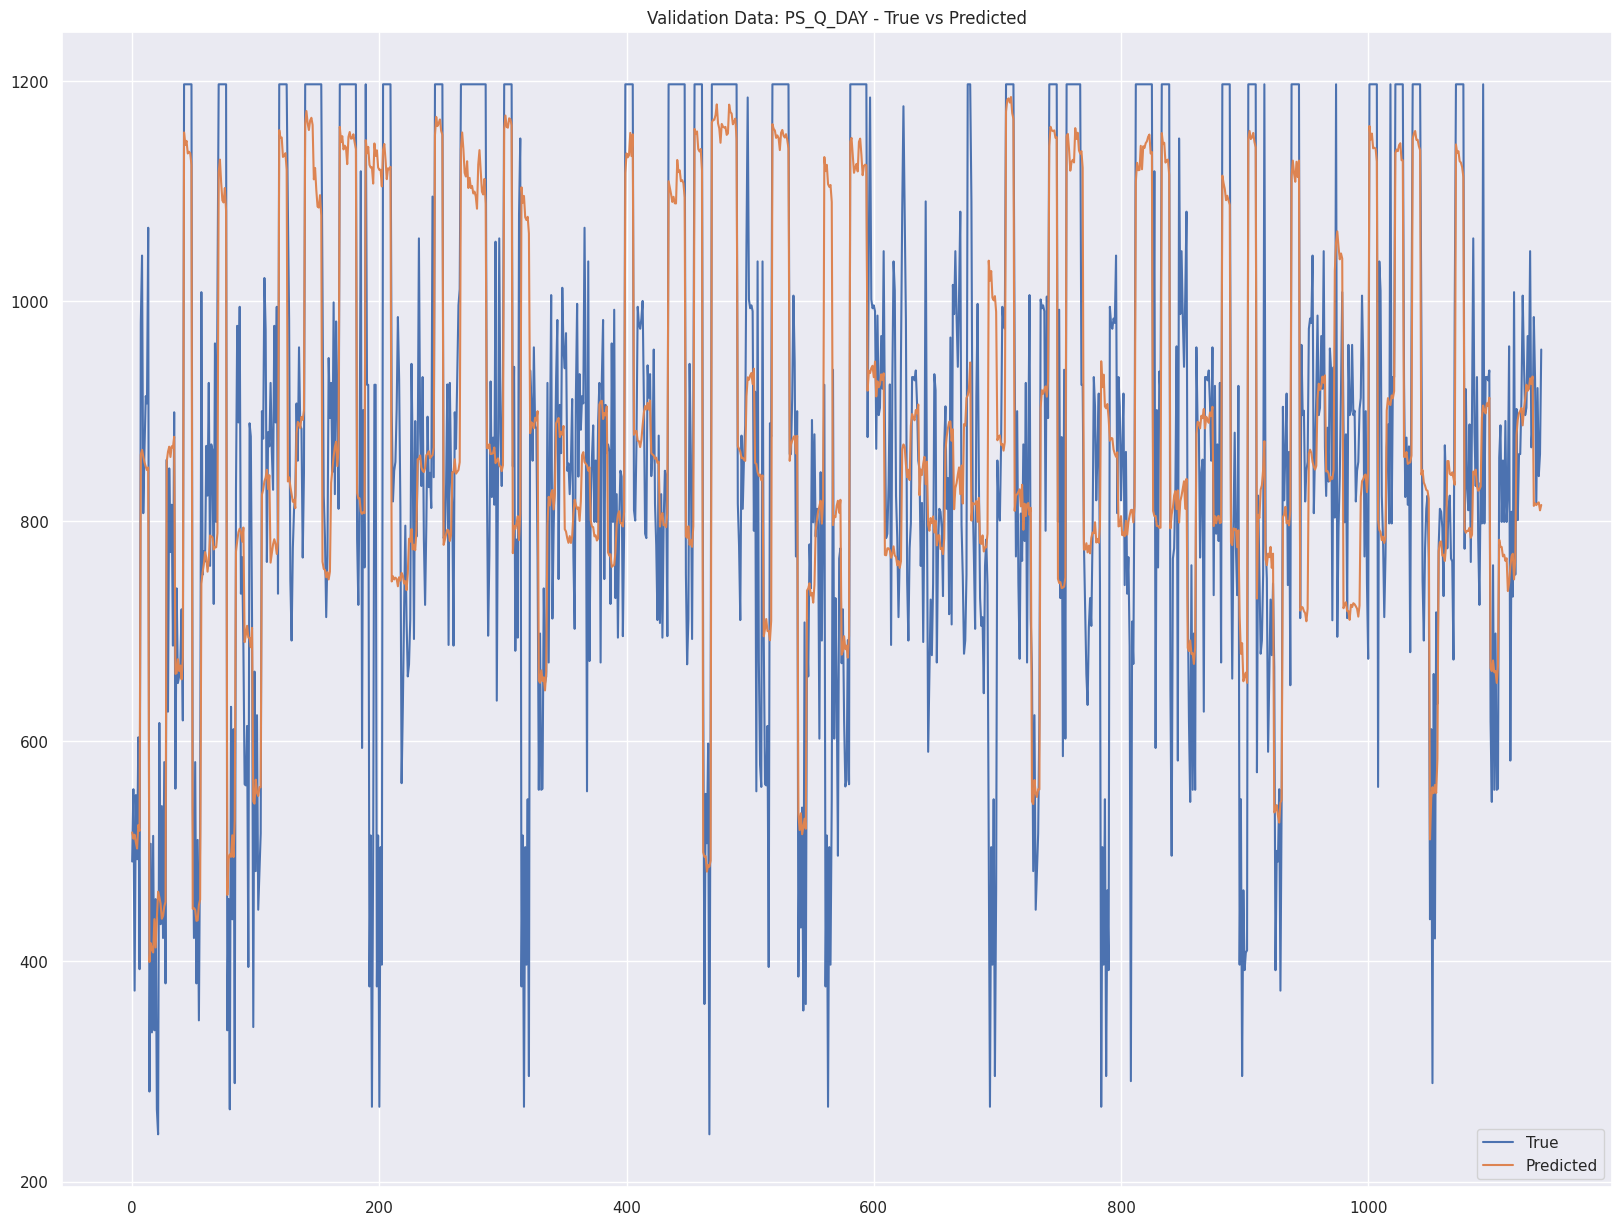

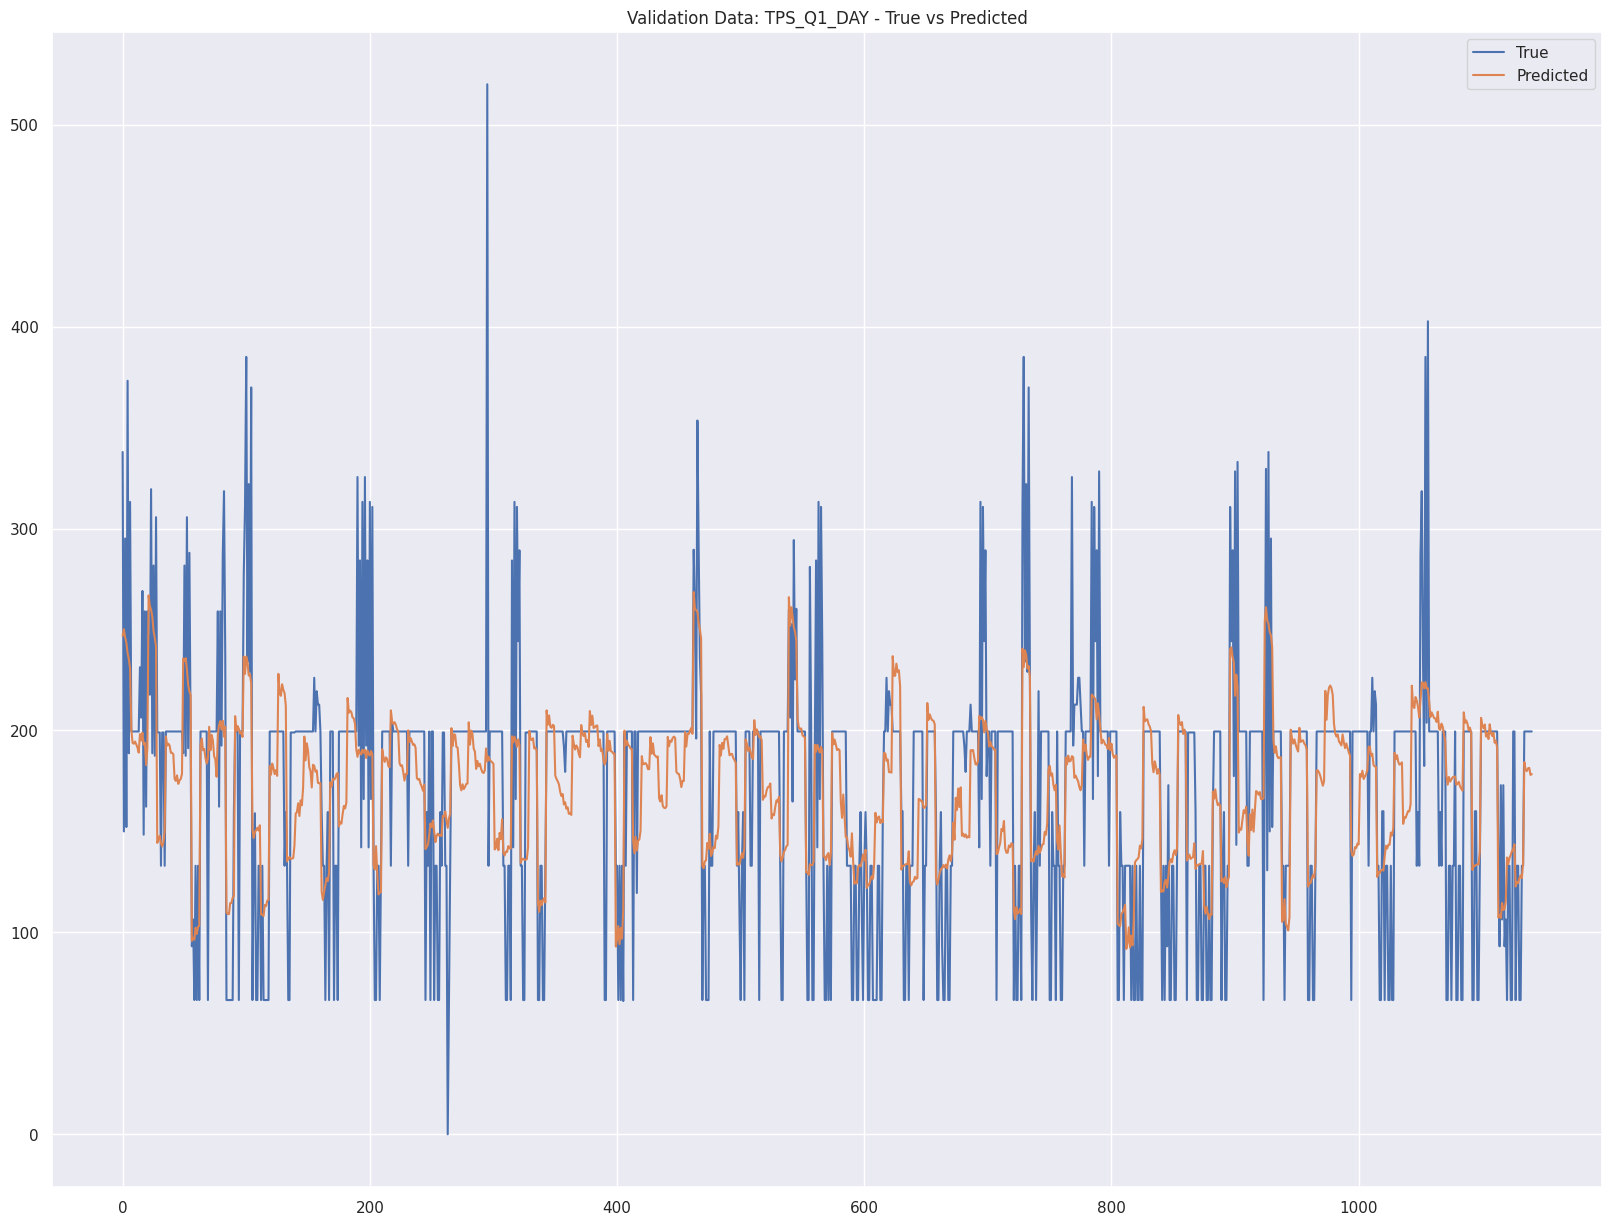

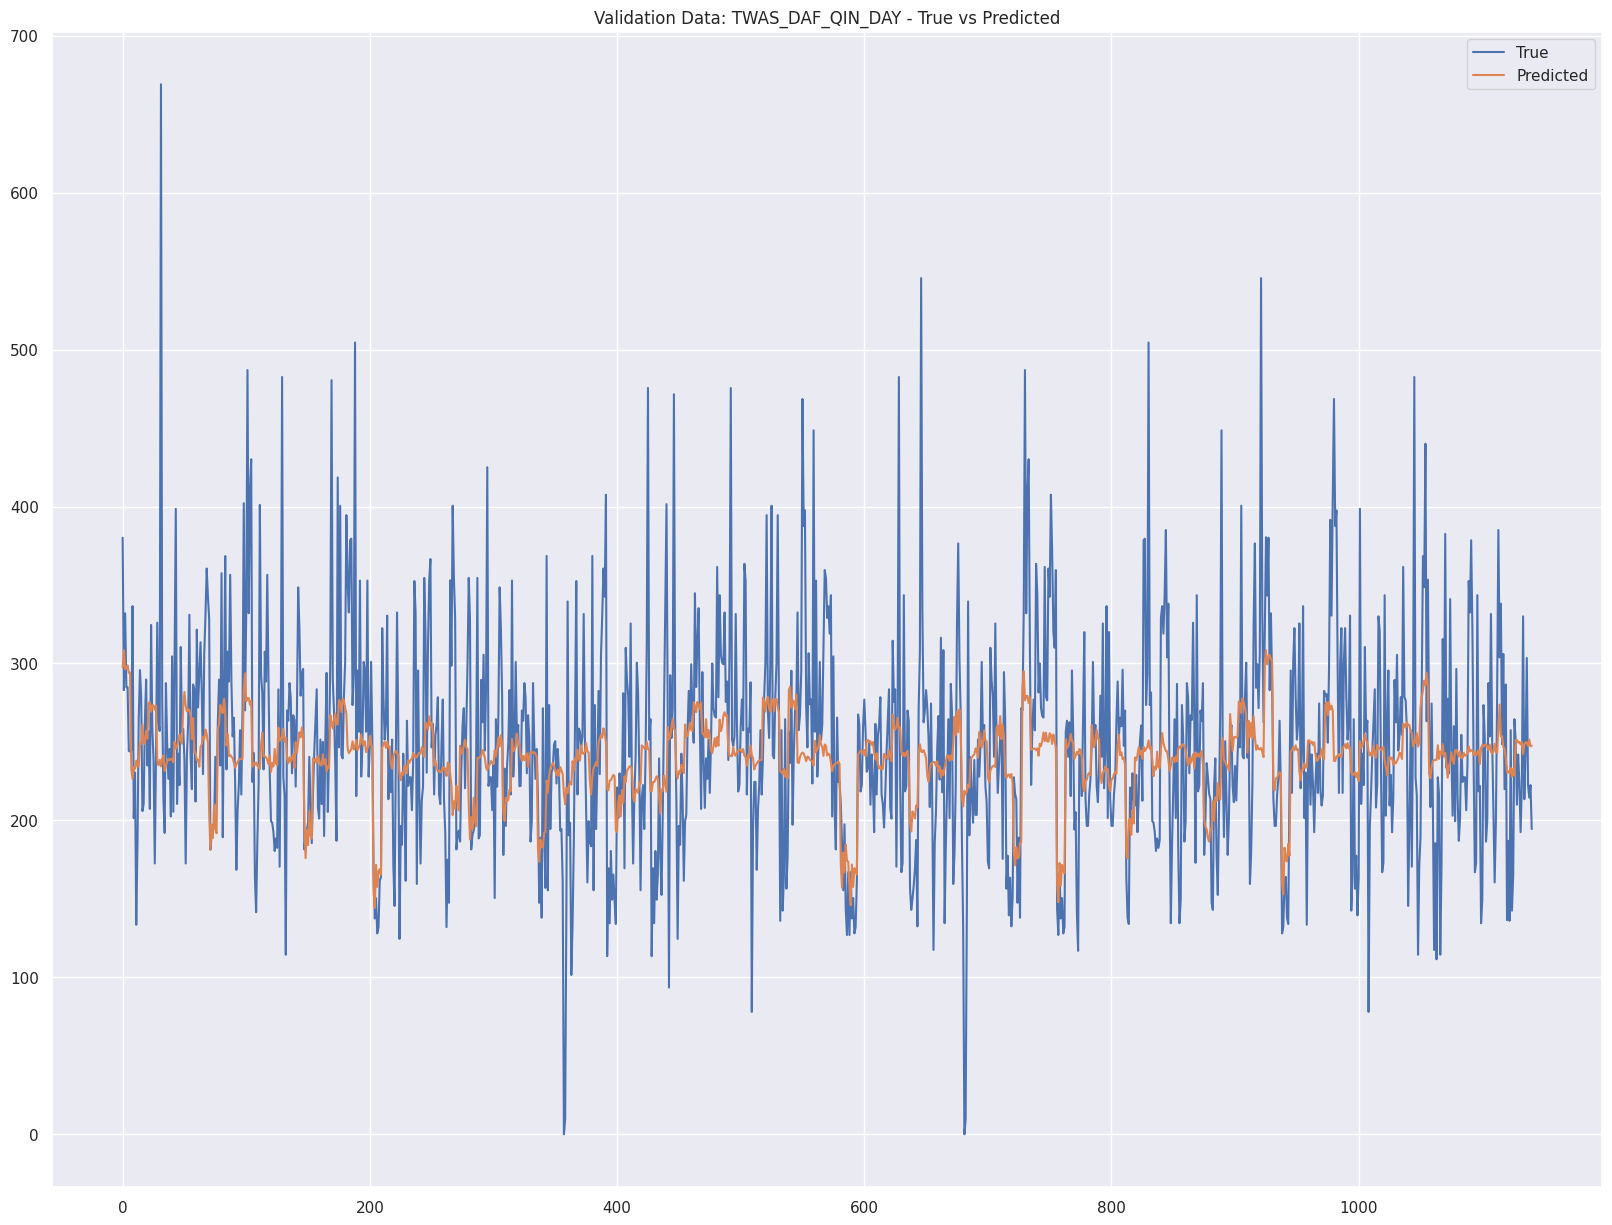

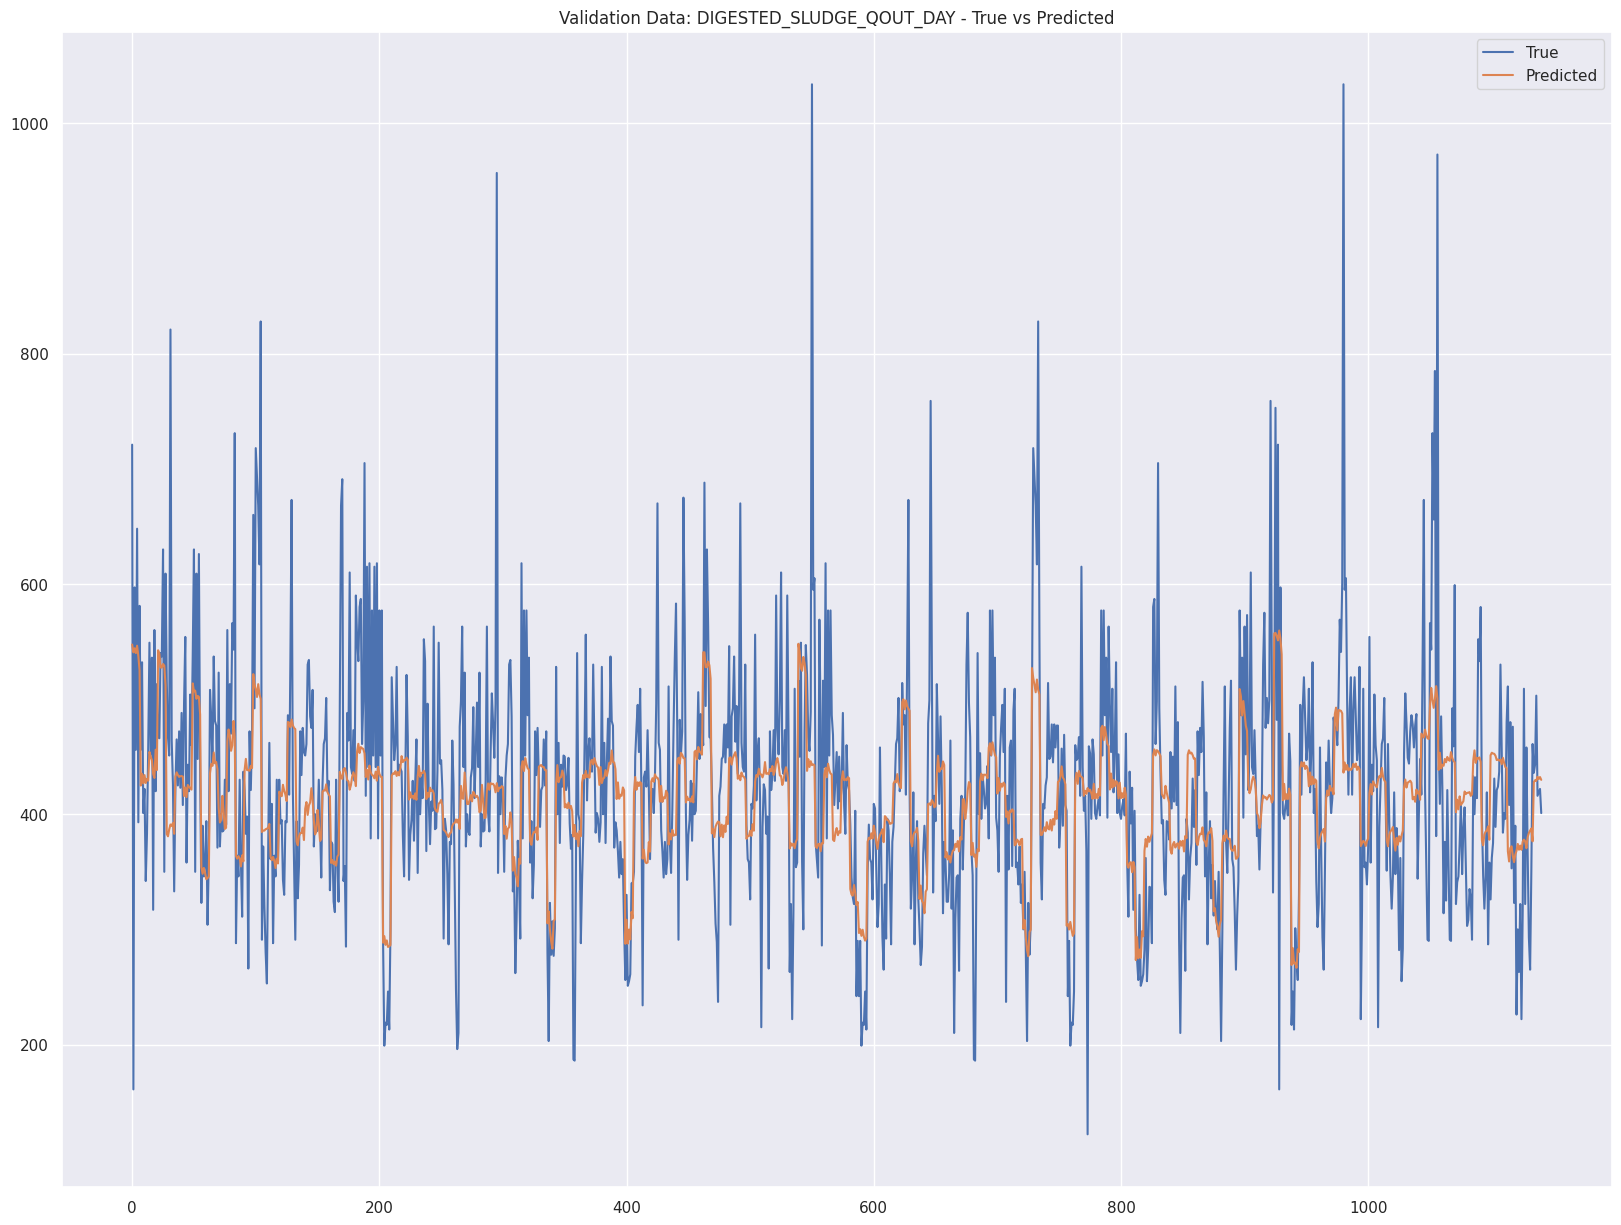

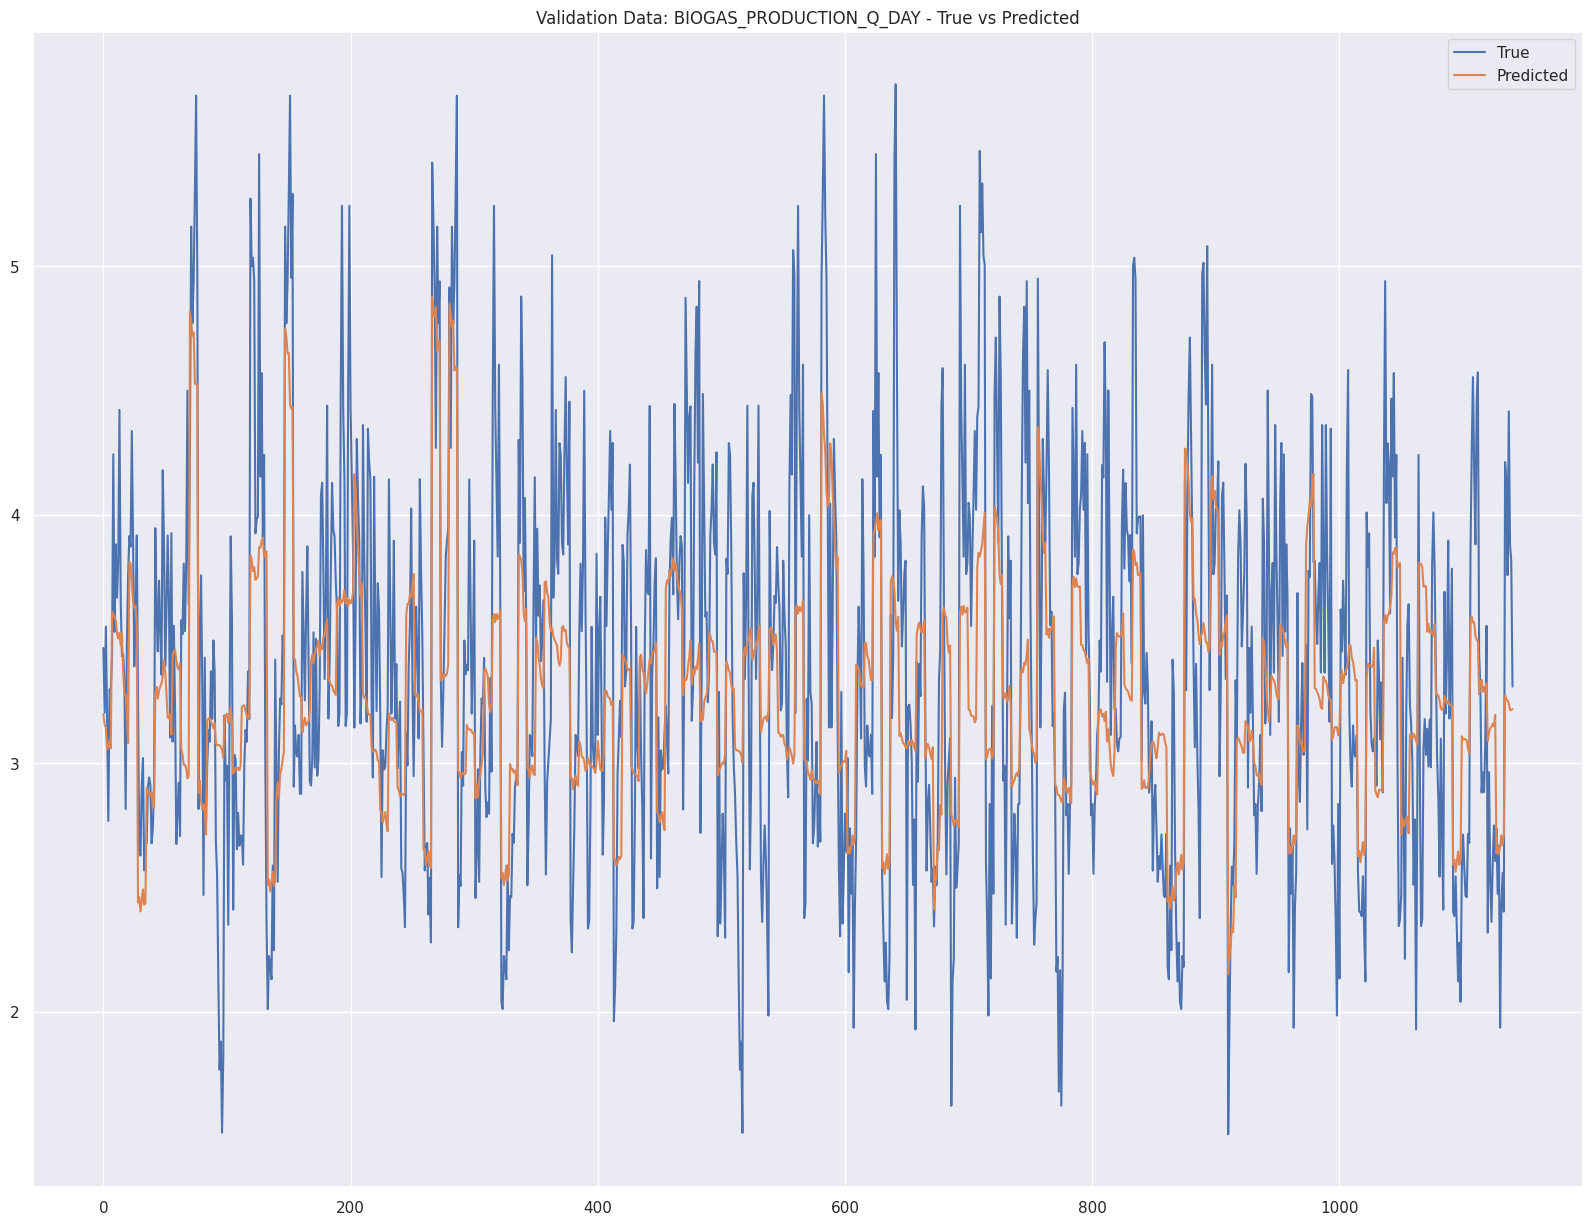

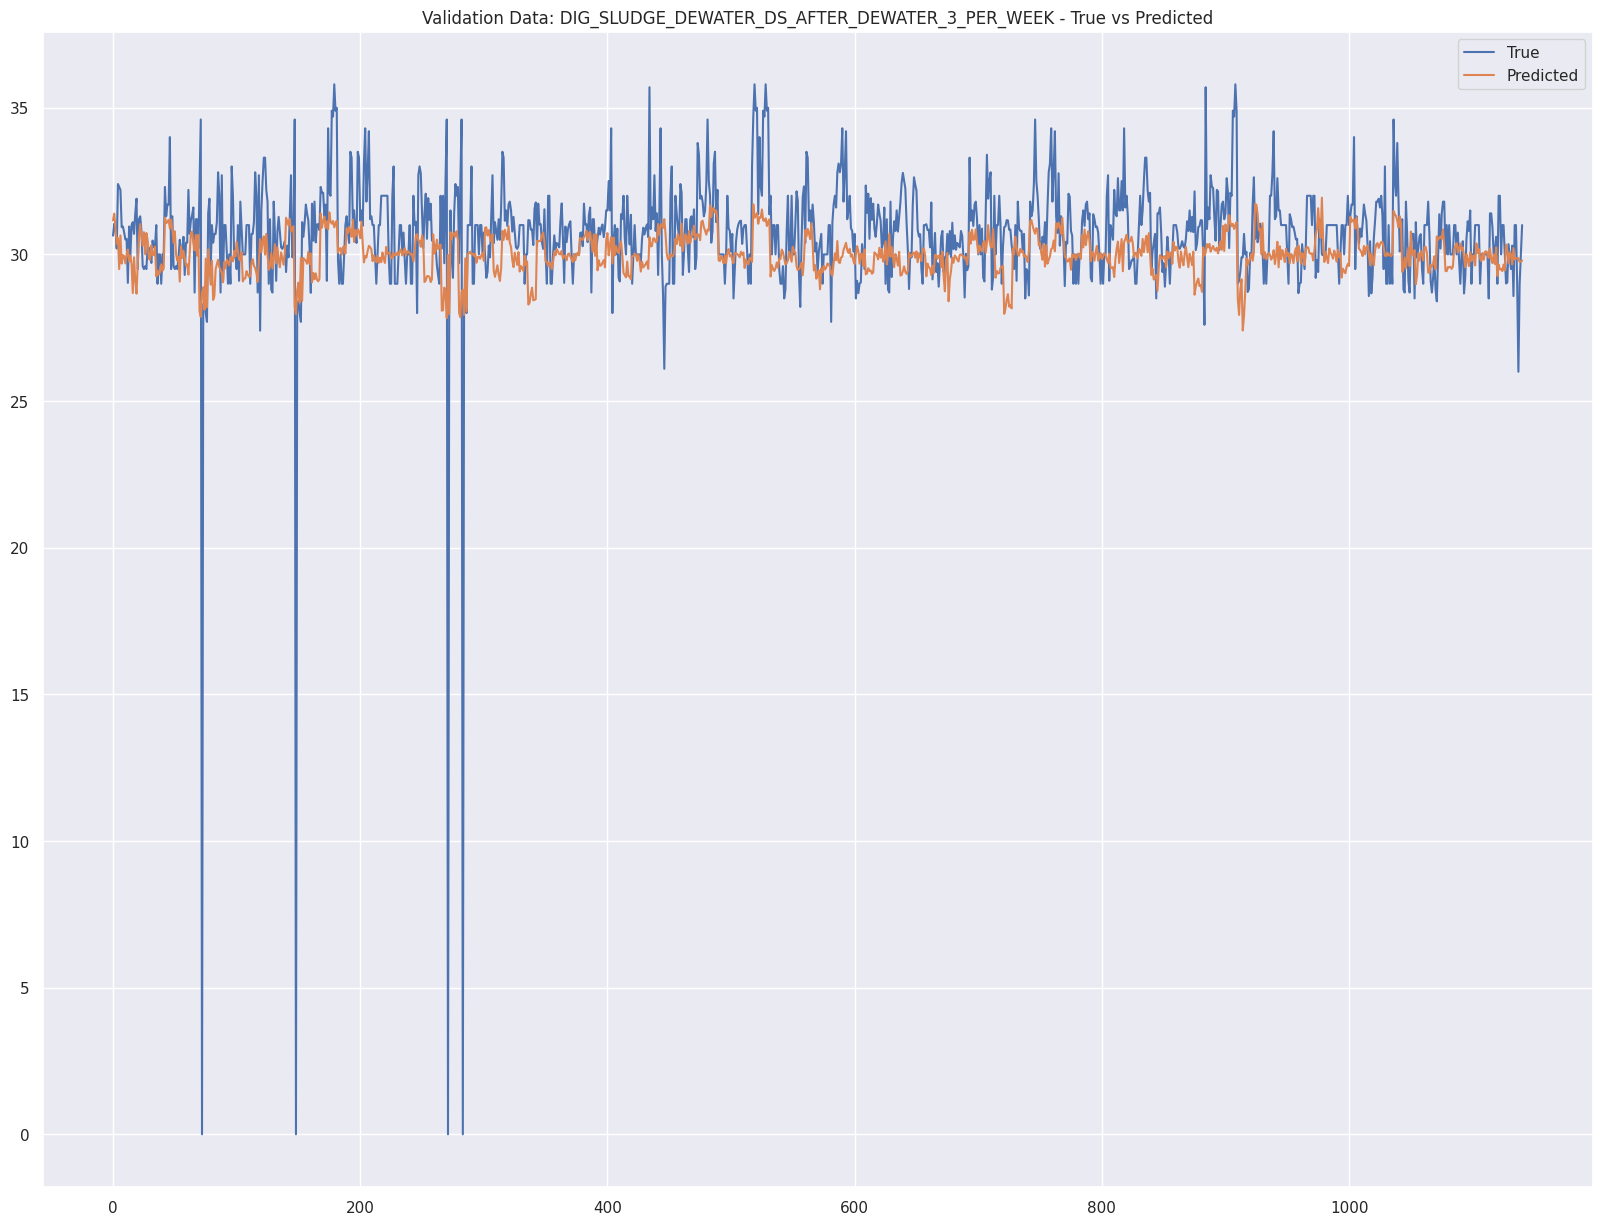

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100


import seaborn as sns

# Define an even larger figure size
sns.set(rc={'figure.figsize':(20, 15)})

# Calculate metrics for each feature separately
for i in range(Y.shape[2]):
    train_mae = mean_absolute_error(Y_train[:, :, i].reshape(-1), train_predict[:, :, i].reshape(-1))
    val_mae = mean_absolute_error(Y_val[:, :, i].reshape(-1), val_predict[:, :, i].reshape(-1))
    train_mse = mean_squared_error(Y_train[:, :, i].reshape(-1), train_predict[:, :, i].reshape(-1))
    val_mse = mean_squared_error(Y_val[:, :, i].reshape(-1), val_predict[:, :, i].reshape(-1))
    train_mape = mean_absolute_percentage_error(Y_train[:, :, i].reshape(-1), train_predict[:, :, i].reshape(-1))
    val_mape = mean_absolute_percentage_error(Y_val[:, :, i].reshape(-1), val_predict[:, :, i].reshape(-1))

    print(f'Feature: {df.columns[i]}')
    print(f'Train MAE: {train_mae}')
    print(f'Validation MAE: {val_mae}')
    print(f'Train MSE: {train_mse}')
    print(f'Validation MSE: {val_mse}')
    print(f'Train MAPE: {train_mape}')
    print(f'Validation MAPE: {val_mape}')
    print("++++++++++++++++++++++++++++")

# Plot true vs predicted values for each feature separately and save the plots
for i in range(Y.shape[2]):
    plt.figure()
    sns.lineplot(data=Y_train[:, :, i].reshape(-1), label='True')
    sns.lineplot(data=train_predict[:, :, i].reshape(-1), label='Predicted')
    plt.title(f'Training Data: {df.columns[i]} - True vs Predicted')
    plt.legend()
    plt.savefig(f'{df.columns[i]}_train.png')  # Save the figure
    plt.show()

for i in range(Y.shape[2]):
    plt.figure()
    sns.lineplot(data=Y_val[:, :, i].reshape(-1), label='True')
    sns.lineplot(data=val_predict[:, :, i].reshape(-1), label='Predicted')
    plt.title(f'Validation Data: {df.columns[i]} - True vs Predicted')
    plt.legend()
    plt.savefig(f'{df.columns[i]}_val.png')  # Save the figure
    plt.show()


In [15]:
from keras.models import load_model

# Load the model
model.save('lstm_model_multi-io-tomorrow.h5')

def forecast_next_day(model, new_row, scaler, look_back):
    # Scale the new row of data
    new_row_scaled = scaler.transform(new_row.reshape(1, -1))

    # Reshape the data to match the input shape for the LSTM model
    new_row_reshaped = np.reshape(new_row_scaled, (1, look_back, new_row_scaled.shape[1]))

    # Perform the forecast
    forecast = model.predict(new_row_reshaped)

    # Invert the scaling
    forecast_inverted = scaler.inverse_transform(forecast)

    return forecast_inverted
